### PyDay Chile 2020

Puedes descargar el dataset utilizado haciendo click [aquí](https://drive.google.com/u/0/uc?export=download&confirm=9sqH&id=1Ugbsw5XbNRbglomSQO1qkAgMFB_3BzmB)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

### 1. Entrenando el modelo Machine Learning con Python

En esta sección, debes entrenar dos modelos de Machine Learning - uno de vecinos más cercanos para predecir el precio de las propiedades tipo `Departamento`, `PH` y `Casa`  en la Ciudad Autónoma de Buenos Aires (`Capital Federal`). Para ello, no debes olvidarte de:

1. Selecciona aquellas propiedades en Capital Federal y cuyo tipo de propiedad es Departamento, PH o Casa.
1. Selecciona aquellas propiedades cuya superficie total es menor a 1000 m2 y mayor a 15 m2.
1. Selecciona aquellas propiedades cuya precio es menor 4000000 dólares.
1. Selecciona las columnas `rooms`, `bedrooms`, `bathrooms`, `surface_total`, `surface_covered` y `price`.
1. Descarta aquellas instacias con valores faltantes.

In [3]:
df = pd.read_csv('data/DS_Proyecto_01_Datos_Properati.csv')

### <font color=Blue>__Filtrado del Dataset__</font>

In [4]:
property_filter = ['Departamento', 'PH', 'Casa']
df = df[(df.property_type.isin(property_filter)) & (df.l2 == "Capital Federal")]
df = df[(df.surface_total >= 15) & (df.surface_total <= 1000)]
df = df[(df.price <= 4000000)]
df = df[df.surface_total >= df.surface_covered]
columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered','price' ]
df = df[columns]
df.dropna(inplace=True)
df.shape

(80276, 6)

In [5]:
df.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
0,7.0,7.0,2.0,140.0,140.0,153000.0
1,2.0,1.0,2.0,70.0,58.0,159000.0
2,2.0,1.0,1.0,45.0,45.0,125000.0
3,2.0,1.0,1.0,85.0,50.0,295000.0
5,2.0,1.0,1.0,56.0,56.0,150000.0


### <font color=Blue>__Correlación__</font>

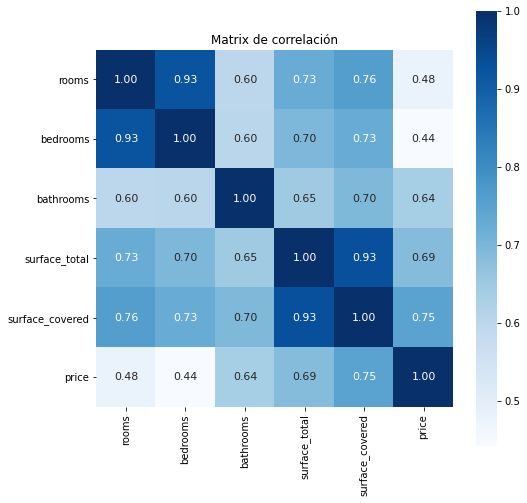

In [6]:
corr = df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 11}, cmap= 'Blues')
plt.title('Matrix de correlación')
plt.show()

### <font color=Blue>__X & y__</font>

In [7]:
X = df[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered' ]]
y = df.price

### <font color=Blue>__Test & Train set__</font>

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler = StandardScaler()

In [9]:
# We scale our data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### <font color=Blue>__3) KNN__</font>

#### <font color=Blue>Buscamos el mejor valor de vecinos</font>

In [10]:
list_mae_train = []
list_mae_test = []
list_rmse_train = []
list_rmse_test = []

k_vecinos = range(1, 30)

for k in k_vecinos:

    clf = KNeighborsRegressor(n_neighbors= k, weights= 'distance')

    clf.fit(X_train, y_train)

    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = clf.predict(X_train)
    train_mae =  mean_absolute_error(y_train_pred, y_train)
    train_rmse =  np.sqrt(mean_squared_error(y_train_pred, y_train))

    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = clf.predict(X_test)
    test_mae = mean_absolute_error(y_test_pred,y_test)
    test_rmse = np.sqrt(mean_squared_error(y_test_pred, y_test))

    list_mae_train.append(train_mae)
    list_mae_test.append(test_mae)
    list_rmse_train.append(train_rmse)
    list_rmse_test.append(test_rmse)

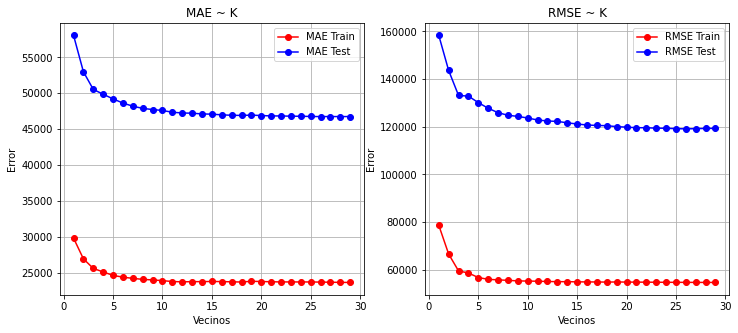

In [11]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
# MAE
axs[0].plot(k_vecinos, list_mae_train,'o-', c='r', label='MAE Train')
axs[0].plot(k_vecinos, list_mae_test,'o-',c='b', label='MAE Test')
axs[0].legend()
axs[0].grid(k_vecinos)
axs[0].set_xlabel('Vecinos')
axs[0].set_ylabel('Error')
axs[0].set_title('MAE ~ K')
#RMSE
axs[1].plot(k_vecinos, list_rmse_train,'o-',c='r', label='RMSE Train')
axs[1].plot(k_vecinos, list_rmse_test,'o-',c='b', label='RMSE Test')
axs[1].legend()
axs[1].grid(k_vecinos)
axs[1].set_xlabel('Vecinos')
axs[1].set_ylabel('Error')
axs[1].set_title('RMSE ~ K')

plt.show()

#### <font color=Blue>El modelo</font>

In [12]:
knn_regressor = KNeighborsRegressor(n_neighbors=20, weights='distance')
knn_regressor.fit(X_train, y_train)

y_train_pred = knn_regressor.predict(X_train)
y_test_pred = knn_regressor.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print('Root Mean Squared Error en Train:',"%.0f" % rmse_train)
print('Root Mean Squared Error en Test:',"%.0f" % rmse_test)
print('Mean Absolute Error en Train:',"%.0f" % mae_train)
print('Mean Absolute Error en Test:',"%.0f" % mae_test)

Root Mean Squared Error en Train: 54852
Root Mean Squared Error en Test: 119817
Mean Absolute Error en Train: 23806
Mean Absolute Error en Test: 46899


#### <font color=Blue>Graficamos la dispersión del error</font>

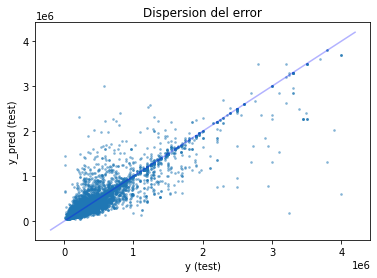

In [13]:
fig, ax = plt.subplots()

ax.scatter(y_test,y_test_pred, s =3, alpha = 0.4)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    
ax.plot(lims, lims, 'k-', alpha=0.3, zorder=1, color='b')

plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
plt.title('Dispersion del error')
plt.show()

### <font color=Blue>__Guardamos el modelo_y el StandardScaler__</font>

In [14]:
model = {"modelo":knn_regressor,
         "scaler":scaler}

with open('./data/model.pickle','wb') as file:
    pickle.dump(model, file)

### <font color=Blue>__Tasador__</font>

In [15]:
# Definimos una clase llamada Property
class Property:

    def __init__(self):
        # To make the instantiation more interactive we will use `input`
        self.rooms = int(input("Rooms: "))
        self.bedrooms = int(input("Bedrooms: "))
        self.bathrooms = int(input("Bathrooms: "))
        self.surface_total = int(input("Surface Total (m2): "))
        self.surface_covered = int(input("Surface Covered (m2): "))

    def __repr__(self):
        return (f'{self.__class__.__name__}('
                f'{self.rooms}, {self.bedrooms}, {self.bathrooms}, '
                f'{self.surface_total}, {self.surface_covered})')


    def predictValue(self, printable = False):
        """
        Returns an estimate price in dollars for the property
        :param printable: Bool - Default: False. Prints a message with the estimated value
        :return: float
        """
        # Create an array with the object attributes
        property_values = [att for att in self.__dict__.values()]
        property_values = np.array(property_values).reshape(1, -1)
        property_values = model["scaler"].transform(property_values)
        price_pred = model["modelo"].predict(property_values)[0] #It's only one value
        if printable:
            print(f'Esta propiedad tiene un valor estimado de: {price_pred:.0f}')
        else:
            return price_pred

#### <font color=Blue>Propiedad de prueba</font>

Propiedad publicada en [Zonaprop](https://www.zonaprop.com.ar/propiedades/departamento-3-ambientes.-las-heras-al-2300-46602803.html)

**Características**
- 3 Ambientes
- 2 Dormitorios
- 2 Baños
- Total 82 m²
- Cubierta 82 m²


USD 265.000

In [16]:
# Iniciaizamos nuestra clase
nueva_prop = Property()
nueva_prop

Property(3, 2, 2, 82, 82)

In [17]:
# Estimamos el valor
nueva_prop.predictValue(printable=True)


Esta propiedad tiene un valor estimado de: 281324
